In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import os
import os.path
import math
from surprise import (Reader, Dataset, NormalPredictor, BaselineOnly,
                      accuracy, SVD, SVDpp, NMF, KNNBasic, KNNWithMeans,
                      KNNWithZScore, KNNBaseline)
from surprise.model_selection import (cross_validate, KFold,
                                      train_test_split, GridSearchCV,
                                      RandomizedSearchCV)

# Always make it pretty.
plt.style.use('ggplot')
%matplotlib inline
sns.set_style(style="whitegrid")

In [5]:
# Load the Yelp business data into a dataframe
business_json_path = 'data/yelp_dataset/yelp_dataset~/yelp_academic_dataset_business.json'
business_df = pd.read_json(business_json_path, lines=True)

In [7]:
# Load the Yelp review data into a dataframe
review_json_path = 'data/yelp_dataset/yelp_dataset~/yelp_academic_dataset_review.json'
review_df = pd.read_json(review_json_path,
                         lines=True,
                         dtype={'review_id': str, 'user_id': str,
                                'business_id': str, 'stars': int,
                                'date': str, 'text': str, 'useful': int,
                                'funny': int, 'cool': int})

In [ ]:
# Load the Yelp user data into a dataframe
user_json_path = 'data/yelp_dataset/yelp_dataset~/yelp_academic_dataset_user.json'
user_df = pd.read_json(user_json_path, lines=True)

In [13]:
# Which cities are most represented in the Yelp dataset?
business_df['city'].value_counts()

Las Vegas            31631
Toronto              20366
Phoenix              20171
Charlotte            10422
Scottsdale            9342
                     ...  
Warrensville             1
Maple Grove              1
New Tecumseth            1
Phoenix Valley           1
Warrensville Hts.        1
Name: city, Length: 1251, dtype: int64

In [14]:
# Examine the review dataframe
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [15]:
# Examine the user dataframe
user_df.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,628,225,227,,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...",14,...,2,1,0,1,11,15,22,22,10,0
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,790,316,400,"2008,2009,2010,2011,2012,2013","ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...",27,...,4,5,2,1,33,37,63,63,21,5
2,zZUnPeh2hEp0WydbAZEOOg,Martin,60,2008-08-28 23:40:05,151,125,103,2010,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...",5,...,6,0,1,0,3,7,17,17,4,1
3,QaELAmRcDc5TfJEylaaP8g,John,206,2008-09-20 00:08:14,233,160,84,2009,"iog3Nyg1i4jeumiTVG_BSA, M92xWY2Vr9w0xoH8bPplfQ...",6,...,1,0,0,0,7,14,7,7,2,0
4,xvu8G900tezTzbbfqmTKvA,Anne,485,2008-08-09 00:30:27,1265,400,512,"2009,2010,2011,2012,2014,2015,2016,2017,2018","3W3ZMSthojCUirKEqAwGNw, eTIbuu23j9tOgmIa9POyLQ...",78,...,9,2,1,1,22,28,31,31,19,31


In [16]:
# Drop unneeded columns for users
user_df.drop(columns=['useful', 'funny', 'cool', 'fans', 'elite',
                      'friends', 'compliment_hot', 'compliment_more',
                      'compliment_profile', 'compliment_cute',
                      'compliment_list', 'compliment_note',
                      'compliment_plain', 'compliment_cool',
                      'compliment_funny', 'compliment_writer',
                      'compliment_photos'],
             axis=1, inplace=True)

In [18]:
# Drop unneeded columns for businesses
business_df.drop(columns=['address', 'postal_code', 'latitude', 'longitude',
                          'attributes', 'hours'],
                 axis=1, inplace=True)

In [23]:
# Drop unneeded columns for reviews
review_df.drop(columns=['useful', 'funny', 'cool'], axis=1, inplace=True)

In [26]:
# Look at the shapes of dataframes after removing columns
print(business_df.shape)
print(user_df.shape)
print(review_df.shape)

(209393, 8)
(1968703, 5)
(8021122, 6)


In [59]:
# Rename columns to avoid mix-ups
review_df.rename(columns={'stars': 'review_stars'}, inplace=True)
business_df.rename(columns={'stars': 'business_stars',
                            'name': 'business_name'}, inplace=True)
user_df.rename(columns={'name': 'user_name'}, inplace=True)

,user_id,user_name,review_count,yelping_since,average_stars
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,3.57
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,3.84
2,zZUnPeh2hEp0WydbAZEOOg,Martin,60,2008-08-28 23:40:05,3.44
3,QaELAmRcDc5TfJEylaaP8g,John,206,2008-09-20 00:08:14,3.08
4,xvu8G900tezTzbbfqmTKvA,Anne,485,2008-08-09 00:30:27,4.37
...,...,...,...,...,...
1968698,gDC6V3sfu9SixRic9hkEQQ,Larry,9,2014-04-27 16:17:05,3.56
1968699,VEAWhS_RF-cKSUflmbCn7Q,Frank,10,2011-10-06 23:38:14,2.30
1968700,toAMthOzk2VDBgpW7Hu3eA,Greg,1,2016-05-08 16:42:58,1.00
1968701,hNX_EqOMImKGUx4g1x532A,RJ,2,2019-06-22 21:39:22,1.00


In [68]:
# Combine review/user/business dfs, specifically for Charlotte restaraunts
review_business_df = review_df.merge(business_df, on='business_id')
all_df = review_business_df.merge(user_df, on='user_id')
charlotte_df = (all_df[(all_df['city'] == 'Charlotte') &
                       (all_df['is_open'] == 1)])
charlotte_df = charlotte_df[charlotte_df['categories'].str.contains(
    'Restaurants', case=False, na=False)]

In [75]:
# Rename columns to avoid mix-ups
all_df.rename(columns={'review_count_x': 'business_review_count',
                       'review_count_y': 'user_review_count'},
              inplace=True)
charlotte_df.rename(columns={'review_count_x': 'business_review_count',
                             'review_count_y': 'user_review_count'},
                    inplace=True)
charlotte_df.reset_index(drop=True, inplace=True)

In [79]:
charlotte_df.head()

,review_id,user_id,business_id,review_stars,text,date,business_name,city,state,business_stars,business_review_count,is_open,categories,user_name,user_review_count,yelping_since,average_stars
0,ML1EIuelvWxb8WOt76iv9w,Xsuv6bKcPUVDWih0DtEBbA,3Ui-76sC9_fNs2gu8ISAMw,4,"In need of lunch and craving pizza, I stumbled...",2012-11-17 02:48:38,Brixx Wood Fired Pizza,Charlotte,NC,3.5,163,1,"Pizza, Restaurants, Salad, Sandwiches, Italian",Liz,454,2010-05-16 16:25:16,3.96
1,lFYxXFcKeIVL7xDyht5Y_g,QEpNF4Hag6_W9Stc-1Frvg,R1jJQi2yR44D_2ileqr8kA,4,Gluten Free: Yes\nCasein Free: Yes\nVegan: Yes...,2016-08-06 03:46:28,Living Kitchen,Charlotte,NC,4.5,502,1,"Vegan, Live/Raw Food, Restaurants, Vegetarian",Stacy,851,2013-02-12 21:21:29,3.70
2,bt-jYgHuSAMO0KiSCtiFBw,QEpNF4Hag6_W9Stc-1Frvg,zrEmWr6ue5yfxnKr4E2_jg,5,"Gluten Free: Yes, item specific\nCasein Free: ...",2018-07-14 06:05:44,Bleu Barn Bistro,Charlotte,NC,4.5,44,1,"Food, Street Vendors, Food Trucks, Event Plann...",Stacy,851,2013-02-12 21:21:29,3.70
3,BXIV_0SZEyeLX6D94ikyPA,QEpNF4Hag6_W9Stc-1Frvg,DTJ9_6yKye0Ul2qG45vGKw,5,"Gluten free- Yes\nCasein free- Yes, just don't...",2017-06-15 04:53:52,Grabbagreen Food + Juice,Charlotte,NC,3.5,28,1,"Juice Bars & Smoothies, Restaurants, Food, Fas...",Stacy,851,2013-02-12 21:21:29,3.70
4,bLmB7p61YxzagnFyVu3-4A,QEpNF4Hag6_W9Stc-1Frvg,RMzjD_LpED02tGGafX0RBw,5,Gluten Free- Yes\nCasein Free - Yes\n\nI have ...,2017-07-09 04:13:30,City Barbeque,Charlotte,NC,4.0,173,1,"Barbeque, American (Traditional), Event Planni...",Stacy,851,2013-02-12 21:21:29,3.70


In [81]:
# Save edited dataframes to csv files
all_df.to_csv('data/all_df.csv')
charlotte_df.to_csv('data/charlotte_df.csv')

(0, 4000)

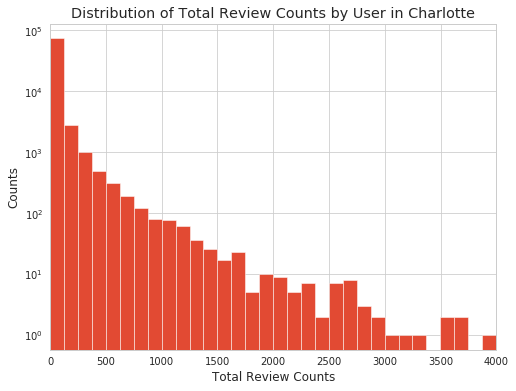

In [100]:
# Look at recorded review count by user
fig, ax = plt.subplots(figsize=(8,6))
charlotte_df.groupby('user_id').mean()['user_review_count'].hist(ax=ax, bins=100)
ax.set_title('Distribution of Total Review Counts by User in Charlotte')
ax.set_xlabel('Total Review Counts')
ax.set_ylabel('Counts')
ax.set_yscale('log')
ax.set_xlim((0,4000))

Text(0, 0.5, 'Counts')

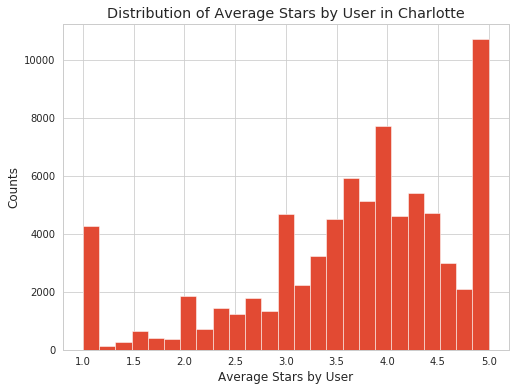

In [105]:
# Average star rating by user
fig, ax = plt.subplots(figsize=(8,6))
charlotte_df.groupby('user_id').mean()['average_stars'].hist(ax=ax, bins=25)
ax.set_title('Distribution of Average Stars by User in Charlotte')
ax.set_xlabel('Average Stars by User')
ax.set_ylabel('Counts')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45017bacd0>]],
      dtype=object)

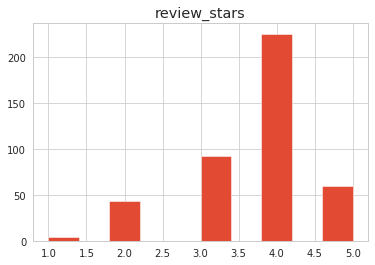

In [107]:
# Review distribution for power user BRUCE
charlotte_df[charlotte_df['user_id'] ==
             'hWDybu_KvYLSdEFzGrniTw'].hist(column='review_stars')

Text(0, 0.5, 'Counts')

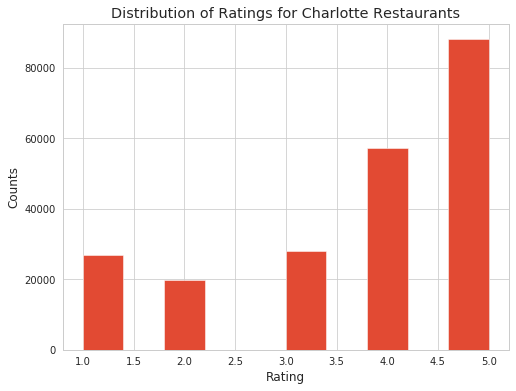

In [108]:
# Distribution of ratings for Charlotte restaurants
fig, ax = plt.subplots(figsize=(8,6))
charlotte_df['review_stars'].hist(ax=ax)
ax.set_title('Distribution of Ratings for Charlotte Restaurants')
ax.set_xlabel('Rating')
ax.set_ylabel('Counts')

In [109]:
charlotte_df['review_stars'].value_counts()

5    88134
4    57245
3    28070
1    26888
2    19904
Name: review_stars, dtype: int64

In [110]:
charlotte_df['review_stars'].mean()

3.7257186445757147

In [119]:
# Get the density of our matrix
unique_users = len(charlotte_df['user_id'].unique())
unique_businesses = len(charlotte_df['business_id'].unique())
total_reviews = charlotte_df.shape[0]
total_reviews / (unique_businesses * unique_users)

0.001380822978796313

In [122]:
charlotte_df.shape[0]

220241

In [123]:
# Examining the most common fast food reviews, out of curiosity
charlotte_df[charlotte_df['categories'].str.contains(
    'fast food', case=False, na=False)]['business_name'].value_counts()

McDonald's                                 1020
Chick-fil-A                                 975
Bojangles' Famous Chicken 'n Biscuits       955
Chipotle Mexican Grill                      710
Wendy's                                     593
Bad Daddy's Burger Bar                      576
Shake Shack                                 428
Taco Bell                                   423
Blaze Fast-Fire'd Pizza                     412
Cook Out                                    393
Benny Pennello's                            374
Domino's                                    372
Jersey Mike's Subs                          341
Jimmy John's                                308
Subway Restaurants                          300
Famous Toastery                             282
MOD Pizza                                   272
Jack in the Box                             247
Burger King                                 243
Zaxby's Chicken Fingers & Buffalo Wings     239
Moe's Southwest Grill                   

In [125]:
# Examine the utility matrix via pivot table
charlotte_pivot = charlotte_df.pivot_table(values='review_stars',
                                           index='user_id',
                                           columns='business_id')

Min number of ratings: 1


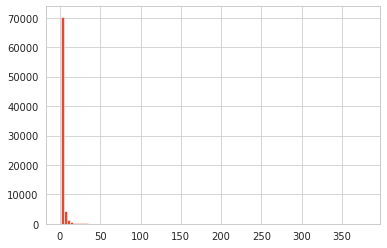

In [129]:
user_ratings = (charlotte_pivot > 0).sum(axis=1)
user_ratings.hist(bins=100)
print('Min number of ratings: {}'.format(user_ratings.min()))

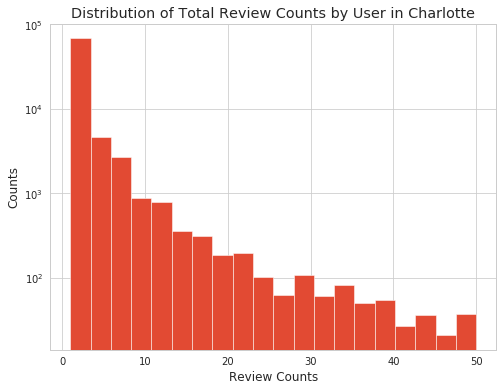

In [151]:
fig, ax = plt.subplots(figsize=(8,6))
user_ratings_50 = user_ratings[user_ratings <= 50]
user_ratings_50.hist(ax=ax, bins=20)
ax.set_title('Distribution of Total Review Counts by User in Charlotte')
ax.set_xlabel('Review Counts')
ax.set_ylabel('Counts')
ax.set_yscale('log')

In [145]:
# How many users only have 1 review?
user_ratings[user_ratings.values == 1].count()

50239

In [146]:
user_ratings[user_ratings.values == 2].count()

11964

In [157]:
# Make a table of review counts for easy comparison
num_of_ratings = []
num_of_reviews = []
for num in range(1,51):
    num_of_ratings.append(num)
    num_of_reviews.append(user_ratings[user_ratings.values == num].count())
d = {'ratings': num_of_ratings, 'count': num_of_reviews}
num_of_df = pd.DataFrame(data=d)
num_of_df.head(50)

,ratings,count
0,1,50239
1,2,11964
2,3,5317
3,4,2844
4,5,1817
5,6,1180
6,7,813
7,8,650
8,9,494
9,10,389


In [156]:
user_ratings[user_ratings.values > 2].count()

16291

Min number of ratings: 3


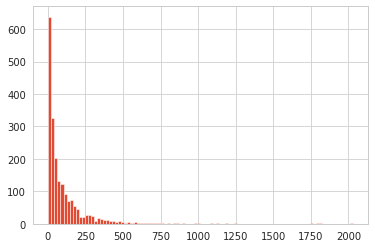

In [132]:
rest_ratings = (charlotte_pivot > 0).sum(axis=0)
rest_ratings.hist(bins=100)
print('Min number of ratings: {}'.format(rest_ratings.min()))

In [133]:
# Create a utility matrix of user ids, business ids, and reviews
utility = charlotte_df[['user_id', 'business_id', 'review_stars']]
utility.head()

,user_id,business_id,review_stars
0,Xsuv6bKcPUVDWih0DtEBbA,3Ui-76sC9_fNs2gu8ISAMw,4
1,QEpNF4Hag6_W9Stc-1Frvg,R1jJQi2yR44D_2ileqr8kA,4
2,QEpNF4Hag6_W9Stc-1Frvg,zrEmWr6ue5yfxnKr4E2_jg,5
3,QEpNF4Hag6_W9Stc-1Frvg,DTJ9_6yKye0Ul2qG45vGKw,5
4,QEpNF4Hag6_W9Stc-1Frvg,RMzjD_LpED02tGGafX0RBw,5


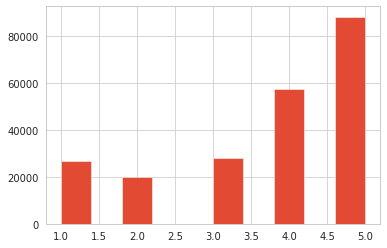

In [134]:
utility['review_stars'].hist()

In [181]:
# Prepare data to run models
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(utility, reader)
trainset, testset = train_test_split(data, test_size=0.3)

In [189]:
# Looking at the trainset in a dataframe
iterator = trainset.all_ratings()
trainset_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in iterator:
    trainset_df.loc[i] = [uid, iid, rating]
    i = i+1

trainset_df.head(2)

,uid,iid,rating
0,0.0,0.0,5.0
1,0.0,346.0,5.0


In [213]:
def inner_to_raw_iid(row):
    '''
    Returns the raw item id associated with a given Surprise inner id
    
    Parameters:
    row: corresponds to a row in a dataframe
    
    Returns:
    output (float): raw item id
    '''
    output = trainset.to_raw_iid(row['iid'])
    return output

In [216]:
def inner_to_raw_uid(row):
    '''
    Returns the raw user id associated with a given Surprise inner id
    
    Parameters:
    row: corresponds to a row in a dataframe
    
    Returns:
    output (float): raw user id
    '''
    output = trainset.to_raw_uid(row['uid'])
    return output

In [195]:
# Place testset into a dataframe
testset_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in testset:
    testset_df.loc[i] = [uid, iid, rating]
    i = i+1

testset_df.head(2)

,uid,iid,rating
0,n5EViMvK5X0b_pjOxmvOxw,MtSEQlqTj3Pup-wBY-dKfA,1.0
1,-G-FF5saVqV3wOlOd9lhAw,RVQE2Z2uky4c0-njFQO66g,4.0


In [218]:
# Convert Surprise inner ids into raw ids
trainset_df['iid'] = trainset_df.apply(inner_to_raw_iid, axis=1)
trainset_df['uid'] = trainset_df.apply(inner_to_raw_uid, axis=1)

In [222]:
trainset_df.head()

,uid,iid,rating
0,mNjK_H5Z-XVucUOFPEZJXg,VHaSjiRqAjrcIFpgG9VUww,5.0
1,mNjK_H5Z-XVucUOFPEZJXg,vodVvMALuQPScQJpLhfcyg,5.0
2,mNjK_H5Z-XVucUOFPEZJXg,qW-JrBmarQFijWWiN0xoTg,5.0
3,mNjK_H5Z-XVucUOFPEZJXg,GiTv0gFXtYFQAzCXnPvepQ,5.0
4,mNjK_H5Z-XVucUOFPEZJXg,NMw6zTXoZDEzNchVIfL1pQ,5.0


In [224]:
# Number of users that are in train and not test
len(np.setdiff1d(testset_df['uid'].unique(), trainset_df['uid'].unique()))

16164

In [225]:
# Number of restaurants that are in train and not test
len(np.setdiff1d(testset_df['iid'].unique(), trainset_df['iid'].unique()))

0

In [196]:
# Random ratings based on distribution of the training set
normal_predictor = NormalPredictor()
normal_predictor.fit(trainset)
predictions = normal_predictor.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.4292
1.4291800047975534
MSE: 3.2390
3.2389547679517454
RMSE: 1.7997
1.7997096343443142


In [197]:
# Baseline ratings
baseline_only = BaselineOnly()
baseline_only.fit(trainset)
predictions = baseline_only.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Estimating biases using als...
MAE:  1.0041
1.004092141115835
MSE: 1.5273
1.5273016906592574
RMSE: 1.2358
1.2358404794548759


In [200]:
# Funk SVD (defaults)
svd = SVD()
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.0003
1.0003392916058484
MSE: 1.5367
1.5367496847148943
RMSE: 1.2397
1.2396570835174114


In [226]:
# NMF (defaults)
nmf = NMF()
nmf.fit(trainset)
predictions = nmf.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.1163
1.116339467275939
MSE: 1.9928
1.9928192166333734
RMSE: 1.4117
1.4116724891536894


In [228]:
utility['user_id'].value_counts()

xDl9ZF3SckkZde_48W6WeA    435
hWDybu_KvYLSdEFzGrniTw    423
Ry1O_KXZHGRI8g5zBR3IcQ    395
qUL3CdRRF1vedNvaq06rIA    365
oIxsWOWytMmV4bf_ffo01w    355
                         ... 
LVucHk3Tu1S7CJdgAW7B_w      1
3nDFLgsjs_QIEpnSmL6Hog      1
FkD-nunEpZHQQnC0zwxFdA      1
MYDDwAl8fQHfECeecYXaLA      1
oPVZJ5CpUrDbgwcDglrRTg      1
Name: user_id, Length: 78494, dtype: int64

In [233]:
# Trim utility matrix to users, restaurants with at least 3 reviews
utility_3 = utility[utility['user_id'].map(utility['user_id']
                                           .value_counts()) >= 3]
utility_3 = utility_3[utility_3['business_id'].map(utility_3['business_id']
                                                   .value_counts()) >= 3]

In [264]:
utility_3.shape

(146135, 3)

In [265]:
# Get updated density (roughly four times higher now)
utility_users = len(utility_3['user_id'].unique())
utility_businesses = len(utility_3['business_id'].unique())
utility_reviews = utility_3.shape[0]
utility_reviews / (utility_businesses * utility_users)

0.0045220782070890565

In [266]:
# Examine dimensions post-trimming
print(utility_users)
print(utility_businesses)
print(utility_reviews)

16718
1933
146135


In [268]:
# Dimensions pre-trimming for comparison
print(unique_users)
print(unique_businesses)
print(total_reviews)

78494
2032
220241


In [272]:
# Create a dataframe of review counts by user
utility_num_of_ratings = []
utility_num_of_reviews = []
for num in range(1, 51):
    utility_num_of_ratings.append(num)
    utility_num_of_reviews.append(
        utility_3_user_ratings[utility_3_user_ratings.values == num].count())
d_3 = {'ratings': utility_num_of_ratings, 'count': utility_num_of_reviews}
num_of_utility_3 = pd.DataFrame(data=d_3)
num_of_utility_3.head(50)

,ratings,count
0,1,42
1,2,398
2,3,5320
3,4,2839
4,5,1811
5,6,1184
6,7,806
7,8,654
8,9,490
9,10,388


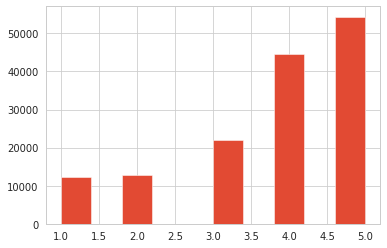

In [273]:
utility_3['review_stars'].hist()

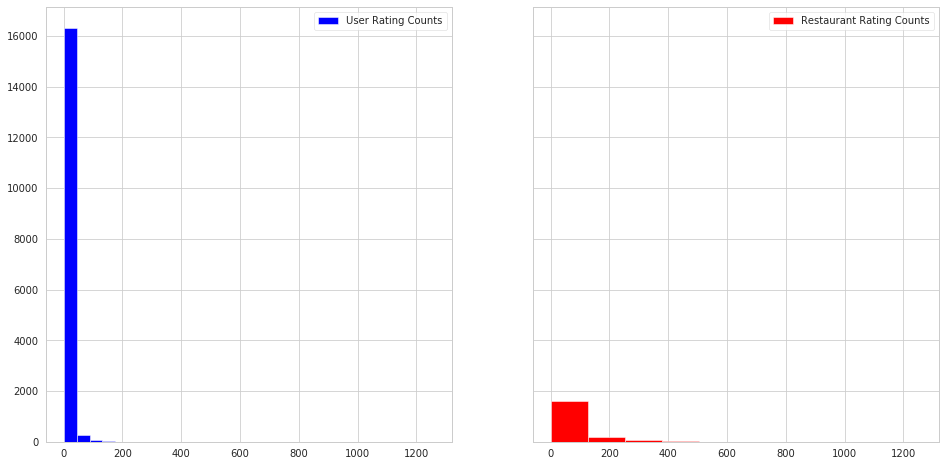

In [275]:
# Examining review distributions on the same scale
utility_user_ratings = utility_3.groupby('user_id').count()['business_id']
utility_rest_ratings = utility_3.groupby('business_id').count()['review_stars']
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True,sharex=True)
ax[0].hist(utility_user_ratings,label='User Rating Counts', color='b')
ax[1].hist(utility_rest_ratings,label='Restaurant Rating Counts', color='r')
ax[0].legend()
ax[1].legend();

In [276]:
# Max values for reviews by user and restaurant
utility_user_ratings.max(), utility_rest_ratings.max()

(435, 1257)

In [277]:
# Minimum values for reviews by user and restaurant
utility_user_ratings.min(), utility_rest_ratings.min()

(2, 3)

In [278]:
# Prepare data for models with adjusted utility matrix
reader = Reader(rating_scale=(1,5))
data_3 = Dataset.load_from_df(utility_3, reader)
trainset_3, testset_3 = train_test_split(data_3, test_size=0.3)

In [279]:
def inner_to_raw_iid_3(row):
    '''
    Returns the raw item id associated with a given Surprise inner id.
    Slightly adjusted from previous function for new trainset.
    
    Parameters:
    row: corresponds to a row in a dataframe
    
    Returns:
    output (float): raw item id
    '''
    output = trainset_3.to_raw_iid(row['iid'])
    return output

def inner_to_raw_uid_3(row):
    '''
    Returns the raw user id associated with a given Surprise inner id
    Slightly adjusted from previous function for new trainset.
    
    Parameters:
    row: corresponds to a row in a dataframe
    
    Returns:
    output (float): raw user id
    '''
    output = trainset_3.to_raw_uid(row['uid'])
    return output

In [280]:
# Place trainset/testset into dataframes
iterator_3 = trainset_3.all_ratings()
trainset_3_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in iterator_3:
    trainset_3_df.loc[i] = [uid, iid, rating]
    i = i+1

testset_3_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in testset_3:
    testset_3_df.loc[i] = [uid, iid, rating]
    i = i+1

trainset_3_df['iid'] = trainset_3_df.apply(inner_to_raw_iid_3, axis=1)
trainset_3_df['uid'] = trainset_3_df.apply(inner_to_raw_uid_3, axis=1)

In [281]:
# Number of users that are in train and not test
len(np.setdiff1d(testset_3_df['uid'].unique(), trainset_3_df['uid'].unique()))

182

In [282]:
# Number of restaurants that are in train and not test
len(np.setdiff1d(testset_3_df['iid'].unique(), trainset_3_df['iid'].unique()))

3

In [283]:
# Random ratings based on distribution of the training set
normal_predictor = NormalPredictor()
normal_predictor.fit(trainset_3)
predictions = normal_predictor.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.3026
1.302621690382496
MSE: 2.7178
2.7178331288828717
RMSE: 1.6486
1.648585190059304


In [284]:
# Baseline ratings
baseline_only = BaselineOnly()
baseline_only.fit(trainset_3)
predictions = baseline_only.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Estimating biases using als...
MAE:  0.8990
0.8990336708056854
MSE: 1.2717
1.2716683608260584
RMSE: 1.1277
1.127682739437852


In [285]:
# NMF (defaults)
nmf = NMF()
nmf.fit(trainset_3)
predictions = nmf.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.9741
0.974143833613901
MSE: 1.6250
1.6249758311084825
RMSE: 1.2747
1.2747453985437573


In [286]:
# Funk SVD (defaults)
svd = SVD()
svd.fit(trainset_3)
predictions = svd.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.8950
0.8949547190708472
MSE: 1.2738
1.2738339931509703
RMSE: 1.1286
1.1286425444537214


In [289]:
# SVD++ (defaults)
svdpp = SVDpp()
svdpp.fit(trainset_3)
predictions = svdpp.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.8921
0.8921401913610161
MSE: 1.2759
1.2759123035813262
RMSE: 1.1296
1.1295628816410914


In [291]:
# KNN (defaults)
knnbasic = KNNBasic()
knnbasic.fit(trainset_3)
predictions = knnbasic.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9372
0.9371977523338367
MSE: 1.4651
1.4650523065011456
RMSE: 1.2104
1.2103934511146142


In [292]:
# KNN with means (defaults)
knnwithmeans = KNNWithMeans()
knnwithmeans.fit(trainset_3)
predictions = knnwithmeans.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9219
0.9219383573733426
MSE: 1.5448
1.5448227684292204
RMSE: 1.2429
1.2429089944276774


In [293]:
# KNN with z-score (defaults)
knnwithzscore = KNNWithZScore()
knnwithzscore.fit(trainset_3)
predictions = knnwithzscore.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9212
0.9212119318702141
MSE: 1.5639
1.563934922607147
RMSE: 1.2506
1.2505738373271476


In [297]:
# Run grid searches to find optimal SVD++ parameters
param_grid = {'n_factors': [10, 20, 50],
              'n_epochs': [20, 30, 40],
              'lr_all': [0.002, 0.007, 0.01],
              'reg_all': [0.01, 0.03, 0.05]}
gs = GridSearchCV(algo_class=SVDpp,
                  param_grid=param_grid,
                  measures = ['rmse', 'mae'],
                  cv=5,
                  n_jobs=-1)
gs.fit(data_3)

In [298]:
gs.best_score['rmse']

1.1146382266319168

In [299]:
gs.best_params['rmse']

{'n_factors': 10, 'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.05}

In [306]:
gs.best_score['mae']

0.8813579181475276

In [308]:
gs.best_params['mae']

{'n_factors': 10, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.05}

In [301]:
param_grid2 = {'n_factors': [10, 12, 14, 16, 20],
               'n_epochs': [15, 20, 25, 30],
               'lr_all': [0.006, 0.007, 0.008],
               'reg_all': [0.04, 0.05, 0.06, 0.07]}
gs2 = GridSearchCV(algo_class=SVDpp,
                   param_grid=param_grid2,
                   measures = ['rmse', 'mae'],
                   cv=5,
                   n_jobs=-1)
gs2.fit(data_3)

In [302]:
gs2.best_params['rmse']

{'n_factors': 14, 'n_epochs': 25, 'lr_all': 0.006, 'reg_all': 0.07}

In [304]:
gs2.best_score['rmse']

1.1129149929184898

In [307]:
gs2.best_params['mae']

{'n_factors': 10, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.07}

In [305]:
gs2.best_score['mae']

0.8785639155118281

In [309]:
param_grid3 = {'n_factors': [20],
               'n_epochs': [20, 25],
               'lr_all': [0.004, 0.006, 0.007, 0.009],
               'reg_all': [0.02, 0.04, 0.05, 0.06, 0.08]}
gs3 = GridSearchCV(algo_class=SVDpp,
                   param_grid=param_grid3,
                   measures = ['rmse', 'mae'],
                   cv=5,
                   n_jobs=-1)
gs3.fit(data_3)

In [310]:
gs3.best_score['rmse']

1.113183782745672

In [311]:
gs3.best_params['rmse']

{'n_factors': 20, 'n_epochs': 25, 'lr_all': 0.006, 'reg_all': 0.08}

In [328]:
gs3.best_params['mae']

{'n_factors': 20, 'n_epochs': 25, 'lr_all': 0.009, 'reg_all': 0.08}

In [313]:
# Save utility matrix to text file in order to explore percentiles
utility_3.to_csv('data/utility.txt', sep='\t', header=False, index=False)

In [314]:
# NOT MY CODE - ADAPTED FROM MANSOURY ET AL'S "FLATTER IS BETTER"
# https://github.com/masoudmansoury/percentile/blob/master/percentile.py

class Percentile:
    def __init__(self):
        # self.fold = 1

        self.transformation_type = "user" # possible values: user and item
        self.percentile_position = "first" # possible values: first, floormedian, ceilmedian, last, and zscore
        self.percentile_smoothed = True # possible values: True and False
        self.percentile_smoothedparam = 5 # a paramter related to smoothing. It's an integer value and will be applied when self.smoothed is True
        self.input = "data/utility.txt"
        self.output = "data/percentile.txt"
        self.dictionary = {}
        self.rating_scale = []

    # creating user/item profile, it would be like <userid/itemid, [rate1, rate2, rate3, ...]>
    def create_profile(self):
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                if self.transformation_type is "user":
                    per.dictionary.setdefault(data[0].rstrip(), []).append(data[2].rstrip())
                elif self.transformation_type is "item":
                    per.dictionary.setdefault(data[1].rstrip(), []).append(data[2].rstrip())

    # percentile computation for first index
    def compute_firstindex_percentile(self):
        self.delete_outputfile()
        out = open(self.output,"w")
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                # sorting the values correspoding to the key e.g., ratings
                i = 0
                if self.transformation_type is "item":
                    i = 1
                values = sorted(map(float,list(per.dictionary.get(data[i].rstrip()))))
                # find the index of the first occurrence of repeated numbers e.g., repeated ratings
                position = values.index(float(data[2].rstrip())) + 1
                # percentile computation
                p = 0.0
                if(self.percentile_smoothed):
                    p = 100 * float(position + ((self.getRatePosition(float(data[2].rstrip())) -1 ) * self.percentile_smoothedparam)) / (len(values) + 1 + (len(self.rating_scale) * self.percentile_smoothedparam))
                else:
                    p = float(100 * position) / float(len(values) + 1)
                out.write(data[0].rstrip() + '\t' + data[1].rstrip() + '\t' + str(p) + '\n')

        out.close()

    # percentile computation for floor median index
    def compute_floormedianindex_percentile(self):
        self.delete_outputfile()
        out = open(self.output,"w")
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                # sorting the values correspoding to the key e.g., ratings
                i = 0
                if self.transformation_type is "item":
                    i = 1
                values = sorted(map(float,list(per.dictionary.get(data[i].rstrip()))))
                # find the index of the floor median occurrence of repeated numbers e.g., repeated ratings
                last = len(values) - 1 - values[::-1].index(float(data[2].rstrip())) + 1
                first = values.index(float(data[2].rstrip())) + 1
                position = int(math.floor(float(last+first))/2)
                # percentile computation
                p = 0.0
                if(self.percentile_smoothed):
                    p = 100 * float(position + ((self.getRatePosition(float(data[2].rstrip()))-1) * self.percentile_smoothedparam) + (int(math.floor(float(self.percentile_smoothedparam/2))))) / (len(values) + 1 + (len(self.rating_scale) * self.percentile_smoothedparam))
                else:
                    p = float(100 * position) / float(len(values) + 1)
                out.write(data[0].rstrip() + '\t' + data[1].rstrip() + '\t' + str(p) + '\n')

        out.close()

    # percentile computation for ceil median index
    def compute_ceilmedianindex_percentile(self):
        self.delete_outputfile()
        out = open(self.output,"w")
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                # sorting the values correspoding to the key e.g., ratings
                i = 0
                if self.transformation_type is "item":
                    i = 1
                values = sorted(map(float,list(per.dictionary.get(data[i].rstrip()))))
                # find the index of the ceil median occurrence of repeated numbers e.g., repeated ratings
                last = len(values) - 1 - values[::-1].index(float(data[2].rstrip())) + 2
                first = values.index(float(data[2].rstrip())) + 1
                position = int(math.ceil(float(last+first))/2)
                # percentile computation
                p = 0.0
                if(self.percentile_smoothed):
                    p = 100 * float(position + ((self.getRatePosition(float(data[2].rstrip()))-1) * self.percentile_smoothedparam) + (int(math.ceil(float(self.percentile_smoothedparam/2))))) / (len(values) + 1 + (len(self.rating_scale) * self.percentile_smoothedparam))
                else:
                    p = float(100 * position) / float(len(values) + 1)
                out.write(data[0].rstrip() + '\t' + data[1].rstrip() + '\t' + str(p) + '\n')

        out.close()

    # percentile computation for last index
    def compute_lastindex_percentile(self):
        self.delete_outputfile()
        out = open(self.output,"w")
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                # sorting the values correspoding to the key e.g., ratings
                i = 0
                if self.transformation_type is "item":
                    i = 1
                values = sorted(map(float,list(per.dictionary.get(data[i].rstrip()))))
                # find the index of the last occurrence of repeated numbers e.g., repeated ratings
                position = len(values) - 1 - values[::-1].index(float(data[2].rstrip())) + 1
                # percentile computation
                p = 0.0
                if(self.percentile_smoothed):
                    p = 100 * float(position + (self.getRatePosition(float(data[2].rstrip())) * self.percentile_smoothedparam)) / (len(values) + 1 + (len(self.rating_scale) * self.percentile_smoothedparam))
                else:
                    p = float(100 * position) / float(len(values) + 1)
                out.write(data[0].rstrip() + '\t' + data[1].rstrip() + '\t' + str(p) + '\n')

        out.close()

    def compute_zscore(self):
        self.delete_outputfile()
        out = open(self.output,"w")
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                # sorting the values correspoding to the key e.g., ratings
                i = 0
                if self.transformation_type is "item":
                    i = 1
                values = sorted(map(float,list(per.dictionary.get(data[i].rstrip()))))
                # compute mean of rating profile
                mean = float(sum(values)) / max(len(values),1)
                # compute standard deviation of rating profile
                nominator = 0.0
                for j in range(len(values)):
                    nominator += math.pow(float(values[j]-mean),2)
                std = math.sqrt(nominator/float(len(values)))
                # zscore computation
                z = 0.0
                if(std != 0.0):
                    z = float(float(data[2].rstrip())-mean)/std
                out.write(data[0].rstrip() + '\t' + data[1].rstrip() + '\t' + str(z) + '\n')

        out.close()

    def transform(self):
        if(self.percentile_position is "first"):
            self.compute_firstindex_percentile()
        elif (self.percentile_position is "floormedian"):
            self.compute_floormedianindex_percentile()
        elif (self.percentile_position is "ceilmedian"):
            self.compute_ceilmedianindex_percentile()
        elif (self.percentile_position is "last"):
            self.compute_lastindex_percentile()
        elif (self.percentile_position is "zscore"):
            self.compute_zscore()

    # delete output file if exists
    def delete_outputfile(self):
        try:
            if os.path.exists(self.output):
                os.remove(self.output)
        except OSError:
            print("error")
            pass

    def getRatePosition(self, rate):
        for i in range(len(self.rating_scale)):
            if rate == self.rating_scale[i]:
                return i + 1
        return 0

    def create_ratingscale(self):
        with open(self.input) as f:
            for line in f:
                rate = line.split("\t")[2]
                if(float(rate) not in self.rating_scale):
                    self.rating_scale.append(float(rate))
        self.rating_scale.sort()

In [315]:
# Convert utility matrix to percentile-based ratings
per = Percentile()
per.create_ratingscale()
per.create_profile()
per.transform()

In [322]:
percentile_df = pd.read_csv('data/percentile.txt',
                            sep='\t',
                            names=utility_3.columns.values)

In [324]:
percentile_df.head()

,user_id,business_id,review_stars
0,QEpNF4Hag6_W9Stc-1Frvg,R1jJQi2yR44D_2ileqr8kA,51.612903
1,QEpNF4Hag6_W9Stc-1Frvg,zrEmWr6ue5yfxnKr4E2_jg,70.967742
2,QEpNF4Hag6_W9Stc-1Frvg,DTJ9_6yKye0Ul2qG45vGKw,70.967742
3,QEpNF4Hag6_W9Stc-1Frvg,RMzjD_LpED02tGGafX0RBw,70.967742
4,QEpNF4Hag6_W9Stc-1Frvg,FGy4UJ1Qri_KruPZiPmWYQ,70.967742


In [325]:
percentile_df['review_stars'].min(), percentile_df['review_stars'].max()

(0.2169197396963124, 95.77464788732394)

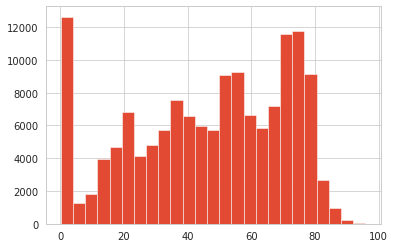

In [327]:
percentile_df['review_stars'].hist(bins=25)

In [ ]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [329]:
# SVD++ 
svdpp = SVDpp(n_factors=20,
              n_epochs=25,
              lr_all=0.006,
              reg_all=0.08)
svdpp.fit(trainset_3)
predictions = svdpp.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.8843
0.8842792095607304
MSE: 1.2468
1.2468167477569905
RMSE: 1.1166
1.1166094875814867


In [332]:
# Place predictions into df
predictions_df = pd.DataFrame(columns=['uid', 'iid', 'true', 'predicted'])
i = 0
for uid, iid, true_r, est, _ in predictions:
    predictions_df.loc[i] = [uid, iid, true_r, est]
    i += 1

In [334]:
predictions_df.shape

(43841, 4)

In [340]:
# Look at prediction distributions in relation to true ratings
predictions_df_1 = predictions_df[predictions_df['true'] == 1]
predictions_df_2 = predictions_df[predictions_df['true'] == 2]
predictions_df_3 = predictions_df[predictions_df['true'] == 3]
predictions_df_4 = predictions_df[predictions_df['true'] == 4]
predictions_df_5 = predictions_df[predictions_df['true'] == 5]

In [342]:
predictions_df_1['predicted'].mean(), predictions_df_1['predicted'].std()

(3.2135224102358126, 0.6820127407408101)

In [343]:
predictions_df_2['predicted'].mean(), predictions_df_2['predicted'].std()

(3.4701400404061538, 0.5629511676275821)

In [344]:
predictions_df_3['predicted'].mean(), predictions_df_3['predicted'].std()

(3.6317928902352747, 0.5004049862855244)

In [345]:
predictions_df_4['predicted'].mean(), predictions_df_4['predicted'].std()

(3.843784864176624, 0.46297482067931395)

In [346]:
predictions_df_5['predicted'].mean(), predictions_df_5['predicted'].std()

(4.0624015137374325, 0.4639703990619268)

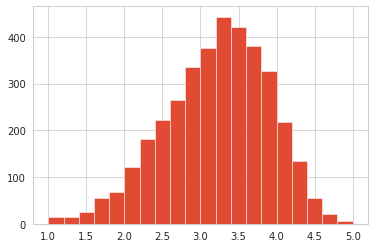

In [358]:
predictions_df_1['predicted'].hist(bins=20)

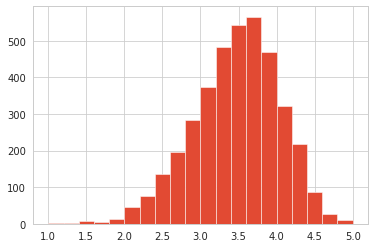

In [357]:
predictions_df_2['predicted'].hist(bins=20)

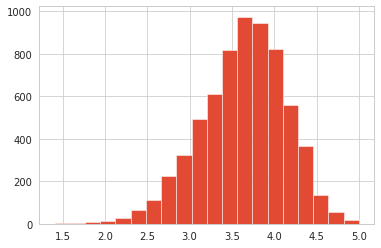

In [356]:
predictions_df_3['predicted'].hist(bins=20)

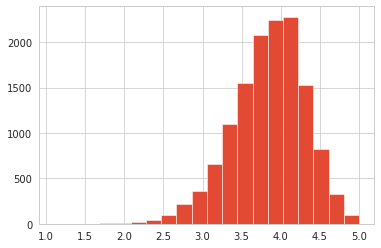

In [355]:
predictions_df_4['predicted'].hist(bins=20)

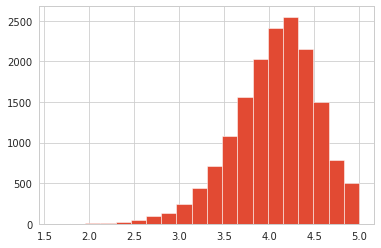

In [354]:
predictions_df_5['predicted'].hist(bins=20)

In [391]:
# Build out anti-testset in order to generate recommendations
full_trainset = data_3.build_full_trainset()
algo = SVDpp(n_factors=20,
             n_epochs=25,
             lr_all=0.006,
             reg_all=0.08)
algo.fit(full_trainset)
full_testset = full_trainset.build_anti_testset()
full_predictions = algo.test(full_testset)
top_n = get_top_n(full_predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

QEpNF4Hag6_W9Stc-1Frvg ['vcVgncax_tbfhMckX1m36w', '5Day_lf10DyvKk9tmKqjRA', 'T1ezuBwruKcJWGKlNTkRNw', '1_pgCgtK2kiM7SyXWbznYQ', '-RTEVGUP2wnKB3PV-_fueg', 'jRxLnJ9my31Re_O2MvQGhw', '3C0bnFhjkgYP9mWORKg6cA', 'BBhGZG0zDMAqIncSqMPfCA', 'K86vnjM11Kkz8532qi0LqQ', 'KrAbQtbH6NWSf3Vlzl5jjg']
iCYMf_sHRevmzWg8la-LVw ['3C0bnFhjkgYP9mWORKg6cA', 'K86vnjM11Kkz8532qi0LqQ', 'KrAbQtbH6NWSf3Vlzl5jjg', 'jRxLnJ9my31Re_O2MvQGhw', 'BBhGZG0zDMAqIncSqMPfCA', 'BYmGU6vw6QFwB4Y5luT3Vw', 'T1ezuBwruKcJWGKlNTkRNw', 'tgxJuRm9EZRfUipsb5rjqg', '1_pgCgtK2kiM7SyXWbznYQ', '5dh5MmyAZExehGndb1IRIQ']
lJFBgSAccsMGwIjfD7LMeQ ['K86vnjM11Kkz8532qi0LqQ', '3C0bnFhjkgYP9mWORKg6cA', '9wCP-MP2B1Yi7EzsM0H0ew', 'T1ezuBwruKcJWGKlNTkRNw', 'jRxLnJ9my31Re_O2MvQGhw', 'tgxJuRm9EZRfUipsb5rjqg', 'BYmGU6vw6QFwB4Y5luT3Vw', 'pkPGkiFYWrB6guAM5BprkQ', 'sHIG0hjQHoxal9a1zwSinw', 'KrAbQtbH6NWSf3Vlzl5jjg']
p4WztGxrJBrVWmt-xmY5Fg ['DWZ0-MtRSJJjHe9VV7yl5A', '5Day_lf10DyvKk9tmKqjRA', 'T1ezuBwruKcJWGKlNTkRNw', '1_pgCgtK2kiM7SyXWbznYQ', 'jRxLnJ9my31Re_O2MvQ

ot0yVHpNJNXNTJvSCD1_nw ['r7QEW42Bqo0KvY2Xb6YDXQ', 'tJHF0eta2A_z5e9nTpONQg', 'YxwxKqemcKwV4vIQXhVv_w', 'DWZ0-MtRSJJjHe9VV7yl5A', 'vcVgncax_tbfhMckX1m36w', '5Day_lf10DyvKk9tmKqjRA', 'ZNA27YNqJPVtN_H76HMFYQ', '6kq9oLduJAYkb2WjAb36KA', 'zpGCFAt_MydbQN4EsXee6w', 'T1ezuBwruKcJWGKlNTkRNw']
MVfJI_knitgdajOGASorwQ ['3C0bnFhjkgYP9mWORKg6cA', 'KrAbQtbH6NWSf3Vlzl5jjg', 'BYmGU6vw6QFwB4Y5luT3Vw', '9wCP-MP2B1Yi7EzsM0H0ew', 'K86vnjM11Kkz8532qi0LqQ', 'jRxLnJ9my31Re_O2MvQGhw', 'T1ezuBwruKcJWGKlNTkRNw', 'pkPGkiFYWrB6guAM5BprkQ', 'sHIG0hjQHoxal9a1zwSinw', 'BBhGZG0zDMAqIncSqMPfCA']
u-NbxbNdh7GZGnwxXUitYg ['3C0bnFhjkgYP9mWORKg6cA', '9wCP-MP2B1Yi7EzsM0H0ew', 'K86vnjM11Kkz8532qi0LqQ', 'tgxJuRm9EZRfUipsb5rjqg', 'T1ezuBwruKcJWGKlNTkRNw', 'KrAbQtbH6NWSf3Vlzl5jjg', 'BBhGZG0zDMAqIncSqMPfCA', '5Day_lf10DyvKk9tmKqjRA', 'IIUK1lz_1upqYtHu8ZuClA', 'ZNA27YNqJPVtN_H76HMFYQ']
3FD37YR27h_KAgmi9Rni2Q ['3C0bnFhjkgYP9mWORKg6cA', '9wCP-MP2B1Yi7EzsM0H0ew', 'K86vnjM11Kkz8532qi0LqQ', 'T1ezuBwruKcJWGKlNTkRNw', 'tgxJuRm9EZRfUipsb5r

fm7QHV2Y1qVyw1jla9MDCg ['3C0bnFhjkgYP9mWORKg6cA', 'KrAbQtbH6NWSf3Vlzl5jjg', '9wCP-MP2B1Yi7EzsM0H0ew', 'BBhGZG0zDMAqIncSqMPfCA', 'tgxJuRm9EZRfUipsb5rjqg', 'BYmGU6vw6QFwB4Y5luT3Vw', 'jRxLnJ9my31Re_O2MvQGhw', 'jsc1SZ9dYG_23zzzurD9GQ', 'K86vnjM11Kkz8532qi0LqQ', '1_pgCgtK2kiM7SyXWbznYQ']
hJDB5QfsmcQOjfYh38G7hQ ['zrEmWr6ue5yfxnKr4E2_jg', 'FGy4UJ1Qri_KruPZiPmWYQ', 'gUrYm7z0g5a5_jdSXzi-HA', 'v72XMTh-dI3L6kHZSRpzpw', 'sAXy1yJRLllTm5WrJbJGAA', 'B1imfnKRvcotaYacPGUrLQ', 'r7QEW42Bqo0KvY2Xb6YDXQ', 'tJHF0eta2A_z5e9nTpONQg', 'dHUb949NckE2GqtlSVlWQg', 'DQIZ35zW26988gl4q_fDHA']
yztzd0dUc5OKZTrzlrmLvQ ['T1ezuBwruKcJWGKlNTkRNw', '3C0bnFhjkgYP9mWORKg6cA', 'K86vnjM11Kkz8532qi0LqQ', 'BBhGZG0zDMAqIncSqMPfCA', 'KrAbQtbH6NWSf3Vlzl5jjg', '9wCP-MP2B1Yi7EzsM0H0ew', 'tgxJuRm9EZRfUipsb5rjqg', 'pkPGkiFYWrB6guAM5BprkQ', 'ZNA27YNqJPVtN_H76HMFYQ', 'jRxLnJ9my31Re_O2MvQGhw']
NEDfFqgzIPumcIYLjhQldQ ['BBhGZG0zDMAqIncSqMPfCA', '3C0bnFhjkgYP9mWORKg6cA', 'K86vnjM11Kkz8532qi0LqQ', 'KrAbQtbH6NWSf3Vlzl5jjg', '9wCP-MP2B1Yi7EzsM0H

iy2ikFy58jLNJv2b70wn_w ['T1ezuBwruKcJWGKlNTkRNw', '3C0bnFhjkgYP9mWORKg6cA', 'K86vnjM11Kkz8532qi0LqQ', '9wCP-MP2B1Yi7EzsM0H0ew', 'BBhGZG0zDMAqIncSqMPfCA', 'KrAbQtbH6NWSf3Vlzl5jjg', 'BYmGU6vw6QFwB4Y5luT3Vw', 'tgxJuRm9EZRfUipsb5rjqg', 'ZNA27YNqJPVtN_H76HMFYQ', 'pkPGkiFYWrB6guAM5BprkQ']
jm_itEOYYxshXgSqbRl9NQ ['3C0bnFhjkgYP9mWORKg6cA', 'KrAbQtbH6NWSf3Vlzl5jjg', 'BBhGZG0zDMAqIncSqMPfCA', 'T1ezuBwruKcJWGKlNTkRNw', 'K86vnjM11Kkz8532qi0LqQ', 'jRxLnJ9my31Re_O2MvQGhw', 'tgxJuRm9EZRfUipsb5rjqg', '1_pgCgtK2kiM7SyXWbznYQ', '9wCP-MP2B1Yi7EzsM0H0ew', 'ByyMZI6YHeBuYlAeQ7DaEw']
V2aZ_b9KLK6wFxTIkcxkTQ ['3C0bnFhjkgYP9mWORKg6cA', 'K86vnjM11Kkz8532qi0LqQ', 'KrAbQtbH6NWSf3Vlzl5jjg', 'BBhGZG0zDMAqIncSqMPfCA', 'T1ezuBwruKcJWGKlNTkRNw', '9wCP-MP2B1Yi7EzsM0H0ew', 'jRxLnJ9my31Re_O2MvQGhw', 'BYmGU6vw6QFwB4Y5luT3Vw', '1_pgCgtK2kiM7SyXWbznYQ', '5Day_lf10DyvKk9tmKqjRA']
HdxVXSSlhufytzVtUK_U4w ['3C0bnFhjkgYP9mWORKg6cA', 'K86vnjM11Kkz8532qi0LqQ', 'BBhGZG0zDMAqIncSqMPfCA', 'jRxLnJ9my31Re_O2MvQGhw', '9wCP-MP2B1Yi7EzsM0H

Tsx_ET41ZR-dxIWhdGw5AA ['3C0bnFhjkgYP9mWORKg6cA', 'KrAbQtbH6NWSf3Vlzl5jjg', 'BBhGZG0zDMAqIncSqMPfCA', 'jRxLnJ9my31Re_O2MvQGhw', '9wCP-MP2B1Yi7EzsM0H0ew', 'tgxJuRm9EZRfUipsb5rjqg', '5Day_lf10DyvKk9tmKqjRA', 'K86vnjM11Kkz8532qi0LqQ', 'BYmGU6vw6QFwB4Y5luT3Vw', 'T1ezuBwruKcJWGKlNTkRNw']
dwOyqcUeLZ-CXvK3vLQ0BQ ['DWZ0-MtRSJJjHe9VV7yl5A', '5Day_lf10DyvKk9tmKqjRA', 'ZNA27YNqJPVtN_H76HMFYQ', 'T1ezuBwruKcJWGKlNTkRNw', '1_pgCgtK2kiM7SyXWbznYQ', 'jRxLnJ9my31Re_O2MvQGhw', '3C0bnFhjkgYP9mWORKg6cA', 'tgxJuRm9EZRfUipsb5rjqg', 'BBhGZG0zDMAqIncSqMPfCA', 'zIELz5s9LknJgaawrwg0Zg']
E-ZAACaiYtfN64y2z3IYLA ['3C0bnFhjkgYP9mWORKg6cA', 'K86vnjM11Kkz8532qi0LqQ', 'BYmGU6vw6QFwB4Y5luT3Vw', 'BBhGZG0zDMAqIncSqMPfCA', 'KrAbQtbH6NWSf3Vlzl5jjg', 'zIELz5s9LknJgaawrwg0Zg', 'T1ezuBwruKcJWGKlNTkRNw', 'jRxLnJ9my31Re_O2MvQGhw', '1_pgCgtK2kiM7SyXWbznYQ', '5dh5MmyAZExehGndb1IRIQ']
bK4Y_GZUoAUTXIrmeEUGYw ['3C0bnFhjkgYP9mWORKg6cA', 'K86vnjM11Kkz8532qi0LqQ', 'KrAbQtbH6NWSf3Vlzl5jjg', '9wCP-MP2B1Yi7EzsM0H0ew', 'BBhGZG0zDMAqIncSqMP

RRGbYyLS9mvDaqlmNbdHQA ['KrAbQtbH6NWSf3Vlzl5jjg', '3C0bnFhjkgYP9mWORKg6cA', 'T1ezuBwruKcJWGKlNTkRNw', 'K86vnjM11Kkz8532qi0LqQ', 'BBhGZG0zDMAqIncSqMPfCA', 'tgxJuRm9EZRfUipsb5rjqg', 'jRxLnJ9my31Re_O2MvQGhw', '9wCP-MP2B1Yi7EzsM0H0ew', 'sHIG0hjQHoxal9a1zwSinw', 'DWZ0-MtRSJJjHe9VV7yl5A']
cjkF_PgzBlCZWHOhVnaK5Q ['T1ezuBwruKcJWGKlNTkRNw', '3C0bnFhjkgYP9mWORKg6cA', '9wCP-MP2B1Yi7EzsM0H0ew', 'KrAbQtbH6NWSf3Vlzl5jjg', 'BBhGZG0zDMAqIncSqMPfCA', 'BYmGU6vw6QFwB4Y5luT3Vw', 'K86vnjM11Kkz8532qi0LqQ', 'pkPGkiFYWrB6guAM5BprkQ', '1_pgCgtK2kiM7SyXWbznYQ', 'jRxLnJ9my31Re_O2MvQGhw']
wSi8PnznGPvG4e7R1xy1jw ['3C0bnFhjkgYP9mWORKg6cA', 'K86vnjM11Kkz8532qi0LqQ', 'KrAbQtbH6NWSf3Vlzl5jjg', 'BBhGZG0zDMAqIncSqMPfCA', '9wCP-MP2B1Yi7EzsM0H0ew', '5Day_lf10DyvKk9tmKqjRA', '5dh5MmyAZExehGndb1IRIQ', 'BYmGU6vw6QFwB4Y5luT3Vw', 'jRxLnJ9my31Re_O2MvQGhw', '1_pgCgtK2kiM7SyXWbznYQ']
wvma7t8p3sXk_0fKxyam8w ['3C0bnFhjkgYP9mWORKg6cA', 'K86vnjM11Kkz8532qi0LqQ', 'KrAbQtbH6NWSf3Vlzl5jjg', 'tgxJuRm9EZRfUipsb5rjqg', '5dh5MmyAZExehGndb1I

XQDfhRd54J7OgimNNxdAcg ['tJHF0eta2A_z5e9nTpONQg', 'DWZ0-MtRSJJjHe9VV7yl5A', '5Day_lf10DyvKk9tmKqjRA', 'ZNA27YNqJPVtN_H76HMFYQ', '6kq9oLduJAYkb2WjAb36KA', 'zpGCFAt_MydbQN4EsXee6w', '0LPVkxZ-Ab9Jx6_ytA-Yew', 'T1ezuBwruKcJWGKlNTkRNw', 'YBhDZMKF_Xfr0z0iqd_tGg', '1_pgCgtK2kiM7SyXWbznYQ']
Bg9Z4365nIgj-YNi0S5EIA ['K86vnjM11Kkz8532qi0LqQ', '3C0bnFhjkgYP9mWORKg6cA', '9wCP-MP2B1Yi7EzsM0H0ew', 'KrAbQtbH6NWSf3Vlzl5jjg', 'T1ezuBwruKcJWGKlNTkRNw', 'BBhGZG0zDMAqIncSqMPfCA', 'BYmGU6vw6QFwB4Y5luT3Vw', 'pkPGkiFYWrB6guAM5BprkQ', 'tgxJuRm9EZRfUipsb5rjqg', 'jRxLnJ9my31Re_O2MvQGhw']
QkbvmZHZj-zZxzsmL467Qw ['T1ezuBwruKcJWGKlNTkRNw', '3C0bnFhjkgYP9mWORKg6cA', 'BBhGZG0zDMAqIncSqMPfCA', '5dh5MmyAZExehGndb1IRIQ', 'K86vnjM11Kkz8532qi0LqQ', 'KrAbQtbH6NWSf3Vlzl5jjg', 'BYmGU6vw6QFwB4Y5luT3Vw', '9wCP-MP2B1Yi7EzsM0H0ew', 'zIELz5s9LknJgaawrwg0Zg', '1_pgCgtK2kiM7SyXWbznYQ']
0wiqr0y1-u0bbNLcbmMJVw ['K86vnjM11Kkz8532qi0LqQ', '3C0bnFhjkgYP9mWORKg6cA', 'KrAbQtbH6NWSf3Vlzl5jjg', '9wCP-MP2B1Yi7EzsM0H0ew', 'BBhGZG0zDMAqIncSqMP

27lSBbQEK6Ef2-K7cNOEDw ['3C0bnFhjkgYP9mWORKg6cA', '9wCP-MP2B1Yi7EzsM0H0ew', 'K86vnjM11Kkz8532qi0LqQ', 'KrAbQtbH6NWSf3Vlzl5jjg', 'T1ezuBwruKcJWGKlNTkRNw', 'ZNA27YNqJPVtN_H76HMFYQ', 'BBhGZG0zDMAqIncSqMPfCA', 'jRxLnJ9my31Re_O2MvQGhw', 'tgxJuRm9EZRfUipsb5rjqg', '1_pgCgtK2kiM7SyXWbznYQ']
atNjcvaX5Nq3-NQVyZQD0g ['3C0bnFhjkgYP9mWORKg6cA', 'BBhGZG0zDMAqIncSqMPfCA', 'K86vnjM11Kkz8532qi0LqQ', 'KrAbQtbH6NWSf3Vlzl5jjg', '5Day_lf10DyvKk9tmKqjRA', '9wCP-MP2B1Yi7EzsM0H0ew', 'T1ezuBwruKcJWGKlNTkRNw', 'tgxJuRm9EZRfUipsb5rjqg', 'jRxLnJ9my31Re_O2MvQGhw', '1_pgCgtK2kiM7SyXWbznYQ']
S5V7w0phgeRc5o6M-_Em5w ['3C0bnFhjkgYP9mWORKg6cA', 'K86vnjM11Kkz8532qi0LqQ', '9wCP-MP2B1Yi7EzsM0H0ew', 'T1ezuBwruKcJWGKlNTkRNw', 'BBhGZG0zDMAqIncSqMPfCA', 'KrAbQtbH6NWSf3Vlzl5jjg', 'tgxJuRm9EZRfUipsb5rjqg', 'BYmGU6vw6QFwB4Y5luT3Vw', 'jRxLnJ9my31Re_O2MvQGhw', '5dh5MmyAZExehGndb1IRIQ']
M_MlYScVbadkrDlJOGtq5g ['3C0bnFhjkgYP9mWORKg6cA', '9wCP-MP2B1Yi7EzsM0H0ew', 'KrAbQtbH6NWSf3Vlzl5jjg', 'K86vnjM11Kkz8532qi0LqQ', 'BBhGZG0zDMAqIncSqMP

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [392]:
top_n['xj09c8_l8rSCI_8_F0yC8Q']

[('3C0bnFhjkgYP9mWORKg6cA', 5),
 ('K86vnjM11Kkz8532qi0LqQ', 5),
 ('T1ezuBwruKcJWGKlNTkRNw', 4.9758372418321315),
 ('BYmGU6vw6QFwB4Y5luT3Vw', 4.933280749115374),
 ('9wCP-MP2B1Yi7EzsM0H0ew', 4.924458737129515),
 ('pkPGkiFYWrB6guAM5BprkQ', 4.90972096736718),
 ('jRxLnJ9my31Re_O2MvQGhw', 4.892936595871806),
 ('sHIG0hjQHoxal9a1zwSinw', 4.889405439351415),
 ('tgxJuRm9EZRfUipsb5rjqg', 4.888642003708359),
 ('5Day_lf10DyvKk9tmKqjRA', 4.876166858766877)]

In [393]:
utility_3[utility_3['user_id'] == 'xj09c8_l8rSCI_8_F0yC8Q']

,user_id,business_id,review_stars
86841,xj09c8_l8rSCI_8_F0yC8Q,T2tEMLpTeSMxLKpxwFdS3g,5
86842,xj09c8_l8rSCI_8_F0yC8Q,YaFM08fEdbp-iSon3Opsbw,4
86843,xj09c8_l8rSCI_8_F0yC8Q,C03ntpeOXOpuNz7ET9sxjw,3
86844,xj09c8_l8rSCI_8_F0yC8Q,H-PmFfqAzQtWTS0XeWC_lw,5
86845,xj09c8_l8rSCI_8_F0yC8Q,HtObLsspK0xIXfNPb7eUmA,5
86846,xj09c8_l8rSCI_8_F0yC8Q,FB2iUwS4-LMLBQVyLZmZfQ,2


In [402]:
def find_and_compare(user_id, top_n):
    '''
    Returns the raw user id associated with a given Surprise inner id

    Arguments:
    user_id (string): user_id string
    top_n (dict): top_n dictionary generated from get_top_n

    Returns:
    reviewed_businesses_df (dataframe): dataframe of businesses reviewed by
    the given user
    recommended_df (dataframe): dataframe of recommended restaurants
    '''
    reviewed_df = utility_3[utility_3['user_id'] == user_id]
    merged_reviewed_df = reviewed_df.merge(right=business_df,
                                           how='left',
                                           left_on='business_id',
                                           right_on='business_id')
    reviewed_businesses_df = merged_reviewed_df[['business_name',
                                                 'review_stars',
                                                 'categories']]

    top_n_df = pd.DataFrame(columns=['business_id', 'predicted'])
    i = 0
    for business, predicted in top_n[user_id]:
        top_n_df.loc[i] = [business, predicted]
        i += 1
    top_n_businesses_df = top_n_df.merge(right=business_df,
                                         how='left',
                                         left_on='business_id',
                                         right_on='business_id')
    recommended_df = top_n_businesses_df[['business_name',
                                          'predicted',
                                          'categories']]

    return reviewed_businesses_df, recommended_df

In [562]:
# Average number of reviews left by a user
utility_3['user_id'].value_counts().mean()

8.741177174303147

In [618]:
# Compare/contrast recommended restaurants and actual reviews provided
actual_df, recommended_df = find_and_compare('fg5-XX6a10nD51kiy1vdCg', top_n)

In [619]:
actual_df

,business_name,review_stars,categories
0,Diamond Restaurant,3,"Restaurants, Diners, American (New), Southern"
1,Jet's Pizza,4,"Restaurants, Pizza"
2,Jasmine Grill,3,"Halal, Mediterranean, Restaurants, Middle Eastern"
3,Le Kebab Grill,4,"Sandwiches, Mediterranean, Middle Eastern, Hal..."
4,Mr. K's Soft Ice Cream & Drive In,3,"Burgers, Food, Restaurants, Ice Cream & Frozen..."
5,Kabuto Japanese Steakhouse and Sushi Bar,5,"Sushi Bars, Restaurants, Japanese, Steakhouses"
6,The Randazzos' Grid Iron,3,"American (New), Italian, Seafood, Nightlife, C..."
7,Showmars Steele Creek,4,"Restaurants, Greek, American (Traditional)"
8,YAFO Kitchen,2,"Restaurants, Ethnic Food, Food, Specialty Food..."
9,Lorenzo's Pizzeria,1,"Pizza, Restaurants, Italian"


In [620]:
recommended_df

,business_name,predicted,categories
0,Chili Man,4.365136,"Hot Dogs, Food, Street Vendors, Restaurants"
1,Enat Ethiopian Restaurant,4.346586,"Vegetarian, Vegan, Ethiopian, African, Restaur..."
2,Lupitas Carniceria & Tortilleria,4.291161,"Food, Restaurants, Mexican"
3,Bar Marcel,4.279530,"French, Italian, Restaurants, Spanish"
4,Alpha Omega Grill & Pizzeria,4.256581,"Restaurants, Pizza, Italian, Mediterranean, Greek"
5,Community Matters Cafe,4.189024,"Breakfast & Brunch, Salad, Sandwiches, Food, R..."
6,Greco Fresh Grille,4.188119,"Greek, Mediterranean, Restaurants"
7,Peppervine,4.172969,"Bars, American (New), Restaurants, Nightlife, ..."
8,The Tasty Bowl Subs N Such,4.170118,"Indian, Italian, Fast Food, Sandwiches, Restau..."
9,Salud Beer Shop,4.162535,"Food, Beer, Wine & Spirits, Wine Bars, Beer Ba..."


In [ ]:
def get_user_totals(uid):
    '''
    Returns the number of items rated by given user
    
    Arguments: 
    uid (string): the id of the user
    
    Returns: 
    (int): the number of items rated by the user
    '''
    try:
        return len(trainset_3.ur[trainset_3.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_item_totals(iid):
    '''
    Returns the number of users that have rated a given item
    
    Arguments:
    iid (string): the raw id of the item
      
    Returns:
    (int): the number of users that have rated the item.
    '''
    try: 
        return len(trainset_3.ir[trainset_3.to_inner_iid(iid)])
    except ValueError:
        return 0

In [376]:
# Generate the best/worst predictions by absolute error
predictions_df['user_totals'] = predictions_df['uid'].apply(get_user_totals)
predictions_df['item_totals'] = predictions_df['iid'].apply(get_item_totals)
predictions_df['err'] = abs(predictions_df['predicted'] -
                            predictions_df['true'])
best_predictions = predictions_df.sort_values(by='err')[:50]
worst_predictions = predictions_df.sort_values(by='err')[-50:]

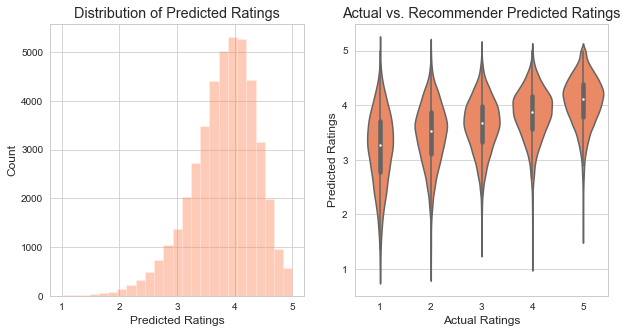

In [16]:
# Plot prediction distributions via histogram & violin plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.distplot(predictions_df['predicted'], bins=25, norm_hist=False,
             color='coral', ax=axs[0], kde=False)
axs[0].set_title('Distribution of Predicted Ratings')
axs[0].set_xlabel('Predicted Ratings')
axs[0].set_ylabel('Count')

pred_data = ([predictions_df['predicted'][predictions_df['true'] == rating]
              .values for rating in range(1, 6)])
sns.violinplot(data=pred_data, ax=axs[1], color='coral')
axs[1].set_title('Actual vs. Recommender Predicted Ratings')
axs[1].set_xlabel('Actual Ratings')
axs[1].set_ylabel('Predicted Ratings')
axs[1].set_xticklabels(np.arange(1,6))

fig.savefig('images/ratingsviolin.png')

In [378]:
best_predictions

,uid,iid,true,predicted,err,user_totals,item_totals
29495,hTjUo_DmadNEHfCVHJ-R6Q,QMOfd4Am5W-_Cmg_pKgzkA,5.0,5.0,0.0,46,9
34010,8BA9P27NAYJ-R7L09XUXJw,80omysuPKac8zn1PfRnQRQ,5.0,5.0,0.0,7,135
35731,UtsI5wQzA5IkxOn6YDLtXQ,hxqy33o5fgJHkYJkpE1ElQ,5.0,5.0,0.0,7,3
35739,uuKOfhxXHZo8J-kLdQmNiA,99j5vhhtFJIefXDLsmA29Q,5.0,5.0,0.0,22,206
41119,-SpxqMoZJjCQ80f2_T4UnA,19fdSca3MUoaGFNX2BrjTQ,5.0,5.0,0.0,19,65
15191,_irsMpu7Cyg34P9byv0SBA,gUrYm7z0g5a5_jdSXzi-HA,5.0,5.0,0.0,7,131
29514,lSjdYb2wussdNmj5XvN45Q,dHUb949NckE2GqtlSVlWQg,5.0,5.0,0.0,19,45
42305,iATUt48CpfNM5wq_XEujLw,Ye6Bdtw2lq5Y6FeX-p377Q,5.0,5.0,0.0,27,41
22940,hTjUo_DmadNEHfCVHJ-R6Q,7HbKKqXtZUjf6uVSHZ8wyw,5.0,5.0,0.0,46,175
27142,a5zmNDY4Cz4Zw6sEFCF97A,9-GNhPL4PBL2FOJc28KPMA,5.0,5.0,0.0,7,27


In [379]:
worst_predictions

,uid,iid,true,predicted,err,user_totals,item_totals
29633,pInF8FmKgca-OKKr02SvjA,YqjDX0TPge-EB73uzgyS3w,1.0,4.494515,3.494515,20,82
20609,5QU93DVWP7PpTnx0HXunYw,3vkP6t_kKN3JT8MMUaBVEA,1.0,4.495046,3.495046,16,205
31124,K1osyO04_hXoDKyGqe_V2Q,vqG1Z2XpS_PryPsfY0CSng,1.0,4.496045,3.496045,45,230
13737,DL9Y_FZEnMxajkWeaBC3Wg,dCHNk6OqM-bYH9JHRZxwvg,1.0,4.496730,3.496730,3,19
11542,hZynhePSGtDHJWY7Dx50tg,VgRcUx2ezIk24DKMSH2YEA,1.0,4.506179,3.506179,4,37
26074,H_BeLMBBUXg0JRqa_tkomg,nHdsHdq35JflGzliWVqG-Q,1.0,4.510243,3.510243,1,64
7455,aJcgNs1SaKepTGSxEidedw,qC9ivAdl47BcZdlbW7ffLg,1.0,4.510788,3.510788,78,65
35695,aJcgNs1SaKepTGSxEidedw,qC9ivAdl47BcZdlbW7ffLg,1.0,4.510788,3.510788,78,65
25834,ZkGpYPgRwihMgRQKsxBaww,ytGKbV7hRC6RkExo1NItEA,1.0,4.511644,3.511644,0,33
29993,bSXpj3DcGFjRTIlFVQIroA,V0iYi5OjdRcz82m95jV7vQ,1.0,4.518983,3.518983,4,67


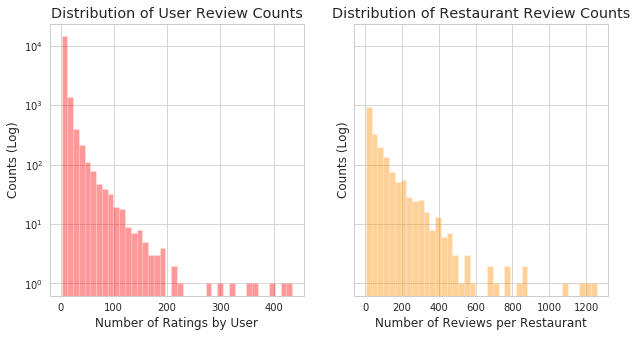

In [428]:
# Plots of user/restaurant review counts
fig, axs = plt.subplots(1,2,figsize=(10,5), sharey=True)

sns.distplot(utility_user_ratings, kde=False, color='red', norm_hist=False,
             ax=axs[0], bins=40)
axs[0].set_title('Distribution of User Review Counts')
axs[0].set_yscale('log')
axs[0].set_xlabel('Number of Ratings by User')
axs[0].set_ylabel('Counts (Log)')

sns.distplot(utility_rest_ratings, color='darkorange', norm_hist=False,
             kde=False, ax=axs[1], bins=40)
axs[1].set_yscale('log')
axs[1].set_title('Distribution of Restaurant Review Counts')
axs[1].set_xlabel('Number of Reviews per Restaurant')
axs[1].set_ylabel('Counts (Log)')

fig.savefig('dist.png')

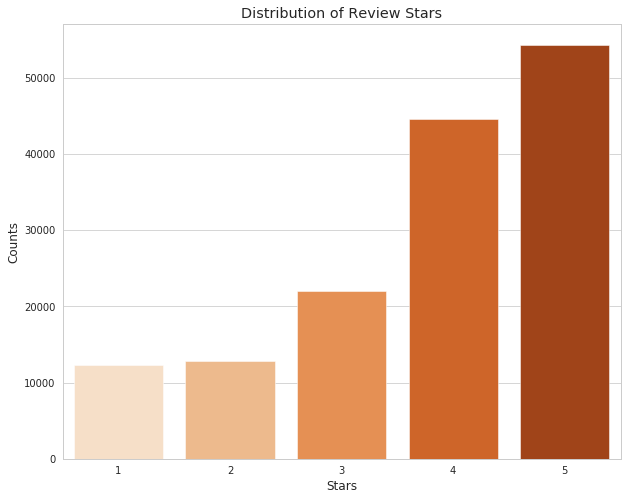

In [440]:
# Bar plot of counts of review stars
fig, ax = plt.subplots(figsize=(10, 8))
utility_review_stars = (utility_3['review_stars']
                        .value_counts(ascending=True))
sns.barplot(x='index', y='review_stars',
            data=utility_review_stars.reset_index(), palette='Oranges',
            ax=ax)
ax.set_title('Distribution of Review Stars')
ax.set_xlabel('Stars')
ax.set_ylabel('Counts')

fig.savefig('reviewcounts.png')

In [490]:
# The following cells evaluate predictions on a user by user basis
# Looking to see how error changes depending on presence in testset
predictions_df[predictions_df['uid'] == 'tDMfIVVzZcRnLcS8jL25Yg']

,uid,iid,true,predicted,err,user_totals,item_totals
15494,tDMfIVVzZcRnLcS8jL25Yg,K5sUVFSGFEZosixSXgx5sw,5.0,3.918567,1.081433,1,185
15895,tDMfIVVzZcRnLcS8jL25Yg,bcTwvbD5wfMSgSO-YczLYw,1.0,4.525002,3.525002,1,164
16752,tDMfIVVzZcRnLcS8jL25Yg,HzvCskRg2IdWFfBcEY5Ryw,5.0,4.242584,0.757416,1,205


In [526]:
calc_rmse = predictions_df[predictions_df['uid'] == 'EtFYEN0sbxkZOOt3DE7vWg']
predictions_df[predictions_df['uid'] == 'EtFYEN0sbxkZOOt3DE7vWg']

,uid,iid,true,predicted,err,user_totals,item_totals
709,EtFYEN0sbxkZOOt3DE7vWg,Oi-u4KqrcZbIWSYKnh7mJA,5.0,3.829043,1.170957,119,43
4431,EtFYEN0sbxkZOOt3DE7vWg,uDb1lOfDhl_VLmAbYvp-vQ,3.0,4.506854,1.506854,119,198
4481,EtFYEN0sbxkZOOt3DE7vWg,QjL_QaEJGRfyBS2-wuowGA,4.0,4.186500,0.186500,119,66
6061,EtFYEN0sbxkZOOt3DE7vWg,UT22ExffDZjB1tzBDwSWfA,4.0,3.986002,0.013998,119,65
6946,EtFYEN0sbxkZOOt3DE7vWg,mC39IrCp36QIVFRZIw9PTQ,4.0,4.262187,0.262187,119,543
8344,EtFYEN0sbxkZOOt3DE7vWg,IIUK1lz_1upqYtHu8ZuClA,5.0,4.853678,0.146322,119,128
8359,EtFYEN0sbxkZOOt3DE7vWg,pldfvm-zM2VU5m9a-j9cMQ,4.0,4.630491,0.630491,119,140
13579,EtFYEN0sbxkZOOt3DE7vWg,oyjkEn5fAqcGNsBbqc8LTw,3.0,2.690715,0.309285,119,53
13916,EtFYEN0sbxkZOOt3DE7vWg,w0ucHqKjiLcUKOicN9Mp8A,5.0,4.600990,0.399010,119,96
16111,EtFYEN0sbxkZOOt3DE7vWg,ALwAlxItASeEs2vYAeLXHA,5.0,4.416757,0.583243,119,577


In [527]:
predictions_df[predictions_df['uid'] == 'EtFYEN0sbxkZOOt3DE7vWg'].shape

(26, 7)

In [528]:
predictions_df[predictions_df['uid'] == 'EtFYEN0sbxkZOOt3DE7vWg']['err'].mean()

0.5201042731658668

In [529]:
((calc_rmse.true - calc_rmse.predicted) ** 2).mean() ** .5

0.718868529249142

In [530]:
user_df[user_df['user_id'] == 'EtFYEN0sbxkZOOt3DE7vWg']

,user_id,user_name,review_count,yelping_since,average_stars
96376,EtFYEN0sbxkZOOt3DE7vWg,Jenny,476,2015-08-01 00:11:43,4.23


In [ ]:
# Save the generated dataframes to csv files for later manipulation
utility_3.to_csv('data/utility.csv')
predictions_df.to_csv('data/predictions.csv')
trainset_3_df.to_csv('data/trainset.csv')
testset_3_df.to_csv('data/testset.csv')

In [41]:
# Loading files for additional graphing
charlotte_df = pd.read_csv('data/charlotte_df.csv')
predictions_df = pd.read_csv('data/predictions.csv')
utility_3 = pd.read_csv('data/utility.csv')

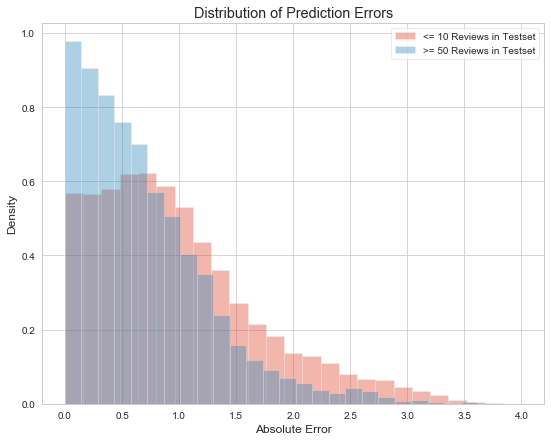

In [32]:
fig, ax = plt.subplots(figsize=(9,7))
user_under = predictions_df[predictions_df['user_totals'] <= 10]
user_over = predictions_df[predictions_df['user_totals'] >= 50]
sns.distplot(user_under['err'], label='<= 10 Reviews in Testset',
             bins=25, ax=ax, norm_hist=True, kde=False)
sns.distplot(user_over['err'], label='>= 50 Reviews in Testset',
             bins=25, ax=ax, norm_hist=True, kde=False)
ax.set_title('Distribution of Prediction Errors')
ax.set_xlabel('Absolute Error')
ax.set_ylabel('Density')
ax.legend()
fig.savefig('images/preddist.png')

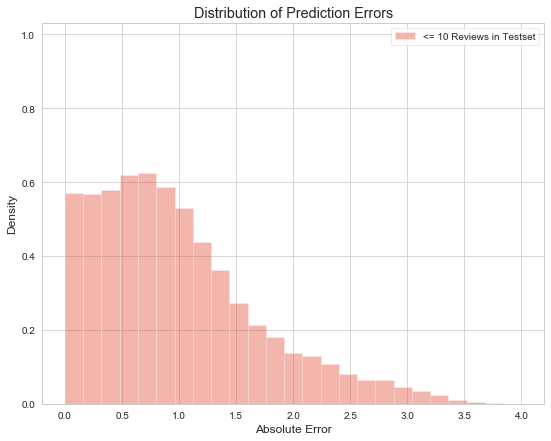

In [40]:
fig, ax = plt.subplots(figsize=(9,7))
sns.distplot(user_under['err'], label='<= 10 Reviews in Testset',
             bins=25, ax=ax, norm_hist=True, kde=False)
ax.set_title('Distribution of Prediction Errors')
ax.set_xlabel('Absolute Error')
ax.set_ylabel('Density')
ax.legend()
ax.set_ylim(0, 1.03)
fig.savefig('images/preddist2.png')